In [ ]:
!pip install scienceplots

In [ ]:
!git clone https://github.com/nmudur/HartreeFock_GPT.git

Cloning into 'HartreeFock_GPT'...
remote: Enumerating objects: 1719, done.
remote: Counting objects: 100% (735/735), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 1719 (delta 471), reused 627 (delta 395), pack-reused 984
Receiving objects: 100% (1719/1719), 51.82 MiB | 29.75 MiB/s, done.
Resolving deltas: 100% (1043/1043), done.


In [ ]:
!pip install openai==0.28
!pip install tiktoken
!pip install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import openai
import pandas as pd
import numpy as np
import json

In [ ]:
from HartreeFock_GPT import utils, annotation_utils, lm_utils

In [ ]:
ARXIV_IDS = annotation_utils.ANNOTATED_PAPERS

In [ ]:
len(ARXIV_IDS)

14

In [ ]:
DATA_DIR = '/content/drive/MyDrive/HF annotation/datasets/execution_updated/'

In [ ]:
ZS_DIR = '/content/drive/MyDrive/HF annotation/datasets/execution_updated/ZeroShot/'

In [ ]:
execution_df = pd.read_csv(os.path.join(ZS_DIR, 'lm_scores_zeroshot_twolevel_final.csv'), dtype={'paper': str})

In [ ]:
execution_df.head()

,paper,task,execution_prompt,lm_execution_completion,score_prompt,lm_score,gt_score_in_paper,gt_score_prompt_quality,gt_score_follow_instructions,gt_score_physics_logic,gt_score_math_derivation,gt_score_final_answer_accuracy
0,1010.1819,Construct Kinetic Hamiltonian (continuum versi...,You will be instructed to describe the kinetic...,The kinetic term of the Hamiltonian in bilayer...,PROBLEM: You will be instructed to describe th...,0,2,1,2,1,2,0
1,1010.1819,Define each term in Kinetic Hamiltonian (conti...,"You will be instructed to construct each term,...","Given the information provided, we are dealing...",PROBLEM: You will be instructed to construct e...,1,2,2,2,2,2,2
2,1010.1819,Convert from single-particle to second-quantiz...,You will be instructed to construct the second...,The Hamiltonian matrix $H_0$ in the basis of $...,PROBLEM: You will be instructed to construct t...,1,0,2,0,2,2,1
3,1010.1819,Convert from single-particle to second-quantiz...,You will be instructed to expand the second-qu...,The second-quantized form of the Hamiltonian $...,PROBLEM: You will be instructed to expand the ...,1,0,2,0,2,2,0
4,1010.1819,Construct interaction Hamiltonian (momentum sp...,You will be instructed to construct the intera...,The interaction part of the Hamiltonian $V^{\k...,PROBLEM: You will be instructed to construct t...,1,1,2,2,2,2,2


In [ ]:
execution_df.columns

Index(['paper', 'task', 'execution_prompt', 'lm_execution_completion',
       'score_prompt', 'lm_score', 'gt_score_in_paper',
       'gt_score_prompt_quality', 'gt_score_follow_instructions',
       'gt_score_physics_logic', 'gt_score_math_derivation',
       'gt_score_final_answer_accuracy'],
      dtype='object')

# Test Scoring Prompt

In [ ]:
#TODO: Add examples to the problem and print periodically the input and output so you can check

In [ ]:
execution_df[(execution_df['paper']=='2308.07488') & (execution_df['task']=='Construct Potential Hamiltonian (continuum version)')]

,paper,task,execution_prompt,lm_execution_completion,score_prompt,lm_score,gt_score_in_paper,gt_score_prompt_quality,gt_score_follow_instructions,gt_score_physics_logic,gt_score_math_derivation,gt_score_final_answer_accuracy
150,2308.07488,Construct Potential Hamiltonian (continuum ver...,You will be instructed to describe the potenti...,The potential Hamiltonian $H_P$ in the real sp...,PROBLEM: You will be instructed to describe th...,1,1,2,1,1,2,1


In [ ]:
execution_df[(execution_df['task']=='Construct Potential Hamiltonian (continuum version)')]

,paper,task,execution_prompt,lm_execution_completion,score_prompt,lm_score,gt_score_in_paper,gt_score_prompt_quality,gt_score_follow_instructions,gt_score_physics_logic,gt_score_math_derivation,gt_score_final_answer_accuracy
45,1812.04213,Construct Potential Hamiltonian (continuum ver...,You will be instructed to describe the potenti...,The potential Hamiltonian $\mathcal{\hat{H}}^{...,PROBLEM: You will be instructed to describe th...,1,1,1,2,2,2,2
90,2108.02159,Construct Potential Hamiltonian (continuum ver...,You will be instructed to describe the potenti...,The potential term of the Hamiltonian ${H_{0}}...,PROBLEM: You will be instructed to describe th...,1,1,2,2,2,2,2
113,2111.01152,Construct Potential Hamiltonian (continuum ver...,You will be instructed to describe the potenti...,The potential term of the Hamiltonian $H_{\tau...,PROBLEM: You will be instructed to describe th...,1,1,2,2,2,2,2
150,2308.07488,Construct Potential Hamiltonian (continuum ver...,You will be instructed to describe the potenti...,The potential Hamiltonian $H_P$ in the real sp...,PROBLEM: You will be instructed to describe th...,1,1,2,1,1,2,1


In [ ]:
execution_df[(execution_df['task']=='Construct Kinetic Hamiltonian (lattice version)')]

,paper,task,execution_prompt,lm_execution_completion,score_prompt,lm_score,gt_score_in_paper,gt_score_prompt_quality,gt_score_follow_instructions,gt_score_physics_logic,gt_score_math_derivation,gt_score_final_answer_accuracy
12,1106.6060,Construct Kinetic Hamiltonian (lattice version),You will be instructed to describe the kinetic...,The kinetic term of the Hamiltonian in the CuO...,PROBLEM: You will be instructed to describe th...,1,2,2,2,2,2,2
32,1310.2674,Construct Kinetic Hamiltonian (lattice version),You will be instructed to describe the kinetic...,The kinetic term of the Hamiltonian in the sec...,PROBLEM: You will be instructed to describe th...,1,2,2,2,2,2,2
55,2004.04168,Construct Kinetic Hamiltonian (lattice version),You will be instructed to describe the kinetic...,The kinetic term of the Hamiltonian in the sec...,PROBLEM: You will be instructed to describe th...,1,2,2,2,2,2,2
66,2008.08998,Construct Kinetic Hamiltonian (lattice version),You will be instructed to describe the kinetic...,The kinetic term of the Hamiltonian in the sec...,PROBLEM: You will be instructed to describe th...,1,2,2,1,2,2,2
77,2012.04554,Construct Kinetic Hamiltonian (lattice version),You will be instructed to describe the kinetic...,The kinetic term of the Hamiltonian in the sec...,PROBLEM: You will be instructed to describe th...,1,2,2,1,2,2,2
100,2110.11330,Construct Kinetic Hamiltonian (lattice version),You will be instructed to describe the kinetic...,The kinetic term of the Hamiltonian in the moi...,PROBLEM: You will be instructed to describe th...,1,2,2,1,2,2,2
137,2308.03843,Construct Kinetic Hamiltonian (lattice version),You will be instructed to describe the kinetic...,The kinetic term of the Hamiltonian in the sec...,PROBLEM: You will be instructed to describe th...,1,2,2,2,2,2,2


In [ ]:
len(execution_df.loc[137]['score_prompt'])

1510

In [ ]:
execution_df.loc[150]

paper                                                                    2308.07488
task                              Construct Potential Hamiltonian (continuum ver...
execution_prompt                  You will be instructed to describe the potenti...
lm_execution_completion           The potential Hamiltonian $H_P$ in the real sp...
score_prompt                      PROBLEM: You will be instructed to describe th...
lm_score                                                                          1
gt_score_in_paper                                                                 1
gt_score_prompt_quality                                                           2
gt_score_follow_instructions                                                      1
gt_score_physics_logic                                                            1
gt_score_math_derivation                                                          2
gt_score_final_answer_accuracy                                              

In [ ]:
execution_df.loc[137]

paper                                                                    2308.03843
task                                Construct Kinetic Hamiltonian (lattice version)
execution_prompt                  You will be instructed to describe the kinetic...
lm_execution_completion           The kinetic term of the Hamiltonian in the sec...
score_prompt                      PROBLEM: You will be instructed to describe th...
lm_score                                                                          1
gt_score_in_paper                                                                 2
gt_score_prompt_quality                                                           2
gt_score_follow_instructions                                                      2
gt_score_physics_logic                                                            2
gt_score_math_derivation                                                          2
gt_score_final_answer_accuracy                                              

In [ ]:
input0 = execution_df.loc[150, 'score_prompt']
score0 = json.dumps({"Score": 0, "Reason": "The SOLUTION does not arrange the matrix elements in the required order."})

In [ ]:
input1 = execution_df.loc[137, 'score_prompt']
score1 = json.dumps({"Score": 1, "Reason": ""})

In [ ]:
print(score0)

{"Score": 0, "Reason": "The SOLUTION does not arrange the matrix elements in the required order."}


In [ ]:
print(score1)

{"Score": 1, "Reason": ""}


In [ ]:
system_prompt_two_level = f"""You are a condensed matter physicist. You need to score the SOLUTION to a described PROBLEM. Your score must either be 0 or 1.
The correctness of the SOLUTION is crucial. Use the following rubric to score the SOLUTION:
Score 1: The SOLUTION is fully correct.
Score 0: The SOLUTION is fully or partially wrong. The SOLUTION may be partially wrong because of minor errors such as incorrect indices.
Your reply must consist of a JSON-parsable dictionary with two keys:
Score: A single integer that is either 0 or 1.
Reason: Your justification for the score. This should be an empty string if the score is 1, or the errors in the solution, if the score is 0.
Use the following examples to learn how to assign scores:
===
EXAMPLE #0:
{input0}{score0}
===
EXAMPLE #1:
{input1}{score1}
===
Now score the following problem and solution:
"""

In [ ]:
print(system_prompt_two_level)

You are a condensed matter physicist. You need to score the SOLUTION to a described PROBLEM. Your score must either be 0 or 1.
The correctness of the SOLUTION is crucial. Use the following rubric to score the SOLUTION:
Score 1: The SOLUTION is fully correct.
Score 0: The SOLUTION is fully or partially wrong. The SOLUTION may be partially wrong because of minor errors such as incorrect indices.
Your reply must consist of a JSON-parsable dictionary with two keys:
Score: A single integer that is either 0 or 1.
Reason: Your justification for the score. This should be an empty string if the score is 1, or the errors in the solution, if the score is 0.
Use the following examples to learn how to assign scores:
===
EXAMPLE #0:
PROBLEM: You will be instructed to describe the potential term of Hamiltonian $H_P$ in the real space in the single-particle form. The potential Hamiltonian has the same degrees of freedom as the kinetic Hamiltonian. The diagonal terms are $\Delta_b(\bm{r})$ and $\Delta_

In [ ]:
# count tokens
N_SYS = lm_utils.get_number_of_tokens_in_line(system_prompt_two_level, 'gpt-4-0613')

In [ ]:
print(N_SYS)

1460


In [ ]:
execution_df = execution_df.reset_index(drop=True)

In [ ]:
N_USR = np.array([lm_utils.get_number_of_tokens_in_line(execution_df.loc[i, 'score_prompt'], 'gpt-4-0613') for i in range(len(execution_df))])

In [ ]:
(N_USR+N_SYS).max()

6248

In [ ]:
# @title Add JSON for key
key_json = "/content/drive/MyDrive/api_keys/openai.json" # @param {type:"string"}
openaikey = json.load(open(key_json, 'r'))['openai']

base_config = {'model_name': 'gpt-4-0613', 'temperature': 0, 'api_key': openaikey}

In [ ]:
base_config['system_prompt'] = system_prompt_two_level

In [ ]:
replies = []
for i in range(len(execution_df)):
  user_prompt = execution_df.loc[i, 'score_prompt']
  lm_score = lm_utils.llm_queries_with_retries(lm_utils.get_openai_llm_response, {'prompt': user_prompt, 'config': base_config}, openai.error.RateLimitError, num_retries=3)
  replies.append(lm_score)
  if i%40 == 0:
    print(f"########Printing Input and LM Score at Problem No. {i}######")
    print(user_prompt)
    print(lm_score['choices'][0]['message']['content'])
    print('#########')

[{'role': 'system', 'content': 'You are a condensed matter physicist. You need to score the SOLUTION to a described PROBLEM. Your score must either be 0 or 1.\nThe correctness of the SOLUTION is crucial. Use the following rubric to score the SOLUTION:\nScore 1: The SOLUTION is fully correct.\nScore 0: The SOLUTION is fully or partially wrong. The SOLUTION may be partially wrong because of minor errors such as incorrect indices.\nYour reply must consist of a JSON-parsable dictionary with two keys:\nScore: A single integer that is either 0 or 1.\nReason: Your justification for the score. This should be an empty string if the score is 1, or the errors in the solution, if the score is 0.\nUse the following examples to learn how to assign scores:\n===\nEXAMPLE #0:\nPROBLEM: You will be instructed to describe the potential term of Hamiltonian $H_P$ in the real space in the single-particle form. The potential Hamiltonian has the same degrees of freedom as the kinetic Hamiltonian. The diagonal

In [ ]:
SAVDIR = os.path.join(DATA_DIR, 'FewShot_Justify_Final')

In [ ]:
json.dump(replies, open(os.path.join(SAVDIR, 'score_replies.json'), 'w'))

The above cell was the last cell you pressed run on!^

### Compile dataframe

In [ ]:
import pandas as pd

In [ ]:
lm_replies_only = [reply['choices'][0]['message']['content'] for reply in replies]

In [ ]:
len(lm_replies_only)

160

In [ ]:
pattern = r'{"Score": (?P<digit>[0-2]), "Reason": (?P<reason>.*)}'

Test pattern

In [ ]:
m = re.fullmatch(pattern, lm_replies_only[3])

In [ ]:
md = m.groupdict()

In [ ]:
md.keys()

dict_keys(['digit', 'reason'])

In [ ]:
md['digit']

'0'

In [ ]:
md['reason']

'"The SOLUTION is incorrect. The diagonal terms $H_{AA}$, $H_{BB}$, $H_{\\\\tilde{A}\\\\tilde{A}}$, and $H_{\\\\tilde{B}\\\\tilde{B}}$ should not be assumed to be zero without any given information. The simplification is therefore incorrect."'

In [ ]:
lm_replies_only

['{"Score": 0, "Reason": "The SOLUTION incorrectly assigns the hopping parameters in the Hamiltonian matrix. The term $\\gamma_4$ is not used, and the arrangement of $\\gamma_0$, $\\gamma_1$, and $\\gamma_3$ does not match the problem\'s instructions."}',
 '{"Score": 1, "Reason": ""}',
 '{"Score": 1, "Reason": ""}',
 '{"Score": 0, "Reason": "The SOLUTION is incorrect. The diagonal terms $H_{AA}$, $H_{BB}$, $H_{\\\\tilde{A}\\\\tilde{A}}$, and $H_{\\\\tilde{B}\\\\tilde{B}}$ should not be assumed to be zero without any given information. The simplification is therefore incorrect."}',
 '{"Score": 1, "Reason": ""}',
 '{"Score": 0, "Reason": "The SOLUTION is incorrect. The problem specifically asked to only preserve the normal terms, which are the product of a creation operator and an annihilation operator. However, the solution includes terms that are the product of two creation operators or two annihilation operators, which are not normal terms."}',
 '{"Score": 1, "Reason": ""}',
 '{"Score

In [ ]:
extracted_lm_scores = []
extracted_lm_reasons = []
errors = []
for ir, lmr in enumerate(lm_replies_only):
  try:
    m = re.fullmatch(pattern, lmr)
    md = m.groupdict()
    extracted_lm_scores.append(int(m['digit']))
    extracted_lm_reasons.append(m['reason'])
  except (KeyError) as e:
    print(ir)
    errors.append((ir, e))
    extracted_lm_scores.append(None)
    extracted_lm_reasons.append(None)

In [ ]:
len(errors)

0

In [ ]:
# check parsed replies
it = 3
print(lm_replies_only[it])
print('Extraction')
print(extracted_lm_reasons[it])
print(extracted_lm_scores[it])

{"Score": 0, "Reason": "The SOLUTION is incorrect. The diagonal terms $H_{AA}$, $H_{BB}$, $H_{\\tilde{A}\\tilde{A}}$, and $H_{\\tilde{B}\\tilde{B}}$ should not be assumed to be zero without any given information. The simplification is therefore incorrect."}
Extraction
"The SOLUTION is incorrect. The diagonal terms $H_{AA}$, $H_{BB}$, $H_{\\tilde{A}\\tilde{A}}$, and $H_{\\tilde{B}\\tilde{B}}$ should not be assumed to be zero without any given information. The simplification is therefore incorrect."
0


In [ ]:
execution_df.columns

Index(['paper', 'task', 'execution_prompt', 'lm_execution_completion',
       'score_prompt', 'lm_score', 'gt_score_in_paper',
       'gt_score_prompt_quality', 'gt_score_follow_instructions',
       'gt_score_physics_logic', 'gt_score_math_derivation',
       'gt_score_final_answer_accuracy'],
      dtype='object')

In [ ]:
execution_df.drop(columns='lm_score', inplace=True)

In [ ]:
len(extracted_lm_scores)

160

In [ ]:
execution_df['lm_score_with_reasoning_value'] = extracted_lm_scores
execution_df['lm_score_with_reasoning_reason'] = extracted_lm_reasons

In [ ]:
SAVDIR

'/content/drive/MyDrive/HF annotation/datasets/execution_updated/FewShot_Justify_Final'

In [ ]:
execution_df.columns

Index(['paper', 'task', 'execution_prompt', 'lm_execution_completion',
       'score_prompt', 'gt_score_in_paper', 'gt_score_prompt_quality',
       'gt_score_follow_instructions', 'gt_score_physics_logic',
       'gt_score_math_derivation', 'gt_score_final_answer_accuracy',
       'lm_score_with_reasoning_value', 'lm_score_with_reasoning_reason'],
      dtype='object')

### Save all data

In [ ]:
execution_df.to_csv(os.path.join(SAVDIR, 'lm_scores_twolevel.csv'), index=False)

## Analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
SAVDIR = os.path.join(DATA_DIR, 'FewShot_Justify_Final')

In [ ]:
score_df = pd.read_csv(os.path.join(SAVDIR, 'lm_scores_twolevel.csv'))

In [ ]:
score_df.head()

,paper,task,execution_prompt,lm_execution_completion,score_prompt,gt_score_in_paper,gt_score_prompt_quality,gt_score_follow_instructions,gt_score_physics_logic,gt_score_math_derivation,gt_score_final_answer_accuracy,lm_score_with_reasoning_value,lm_score_with_reasoning_reason
0,1010.1819,Construct Kinetic Hamiltonian (continuum versi...,You will be instructed to describe the kinetic...,The kinetic term of the Hamiltonian in bilayer...,PROBLEM: You will be instructed to describe th...,2,1,2,1,2,0,0,"""The SOLUTION incorrectly assigns the hopping ..."
1,1010.1819,Define each term in Kinetic Hamiltonian (conti...,"You will be instructed to construct each term,...","Given the information provided, we are dealing...",PROBLEM: You will be instructed to construct e...,2,2,2,2,2,2,1,""""""
2,1010.1819,Convert from single-particle to second-quantiz...,You will be instructed to construct the second...,The Hamiltonian matrix $H_0$ in the basis of $...,PROBLEM: You will be instructed to construct t...,0,2,0,2,2,1,1,""""""
3,1010.1819,Convert from single-particle to second-quantiz...,You will be instructed to expand the second-qu...,The second-quantized form of the Hamiltonian $...,PROBLEM: You will be instructed to expand the ...,0,2,0,2,2,0,0,"""The SOLUTION is incorrect. The diagonal terms..."
4,1010.1819,Construct interaction Hamiltonian (momentum sp...,You will be instructed to construct the intera...,The interaction part of the Hamiltonian $V^{\k...,PROBLEM: You will be instructed to construct t...,1,2,2,2,2,2,1,""""""


In [ ]:
score_df.columns

Index(['paper', 'task', 'execution_prompt', 'lm_execution_completion',
       'score_prompt', 'gt_score_in_paper', 'gt_score_prompt_quality',
       'gt_score_follow_instructions', 'gt_score_physics_logic',
       'gt_score_math_derivation', 'gt_score_final_answer_accuracy',
       'lm_score_with_reasoning_value', 'lm_score_with_reasoning_reason'],
      dtype='object')

In [ ]:
gpt_scores = score_df['lm_score_with_reasoning_value'].to_numpy()
gpt_scores = np.array([int(s) for s in gpt_scores])
ground_truth_faa_scores = score_df['gt_score_final_answer_accuracy'].to_numpy()
ground_truth_faa_scores = np.array([int(s)  if s != 'NA' else np.nan for s in ground_truth_faa_scores])

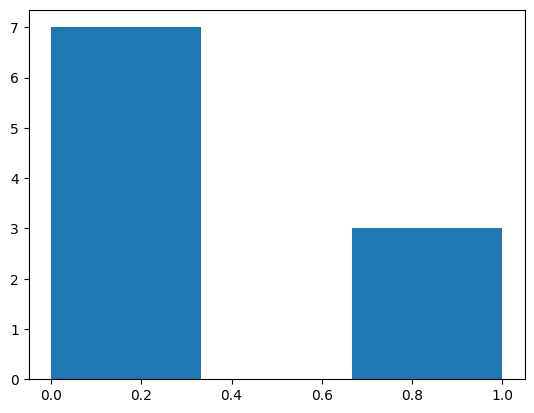

In [ ]:
true_score = 0
mask = (ground_truth_faa_scores==true_score)
plt.figure()
plt.hist(gpt_scores[mask], bins=3)
plt.show()

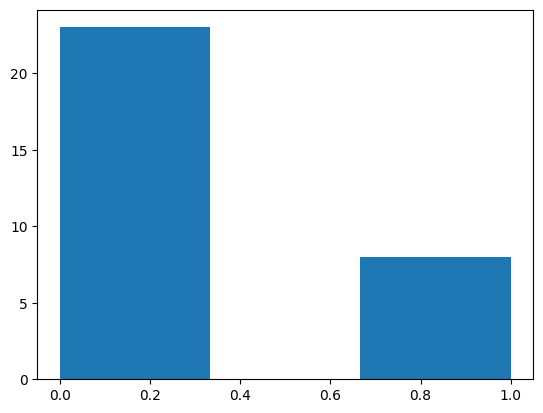

In [ ]:
true_score = 1
mask = (ground_truth_faa_scores==true_score)
plt.figure()
plt.hist(gpt_scores[mask], bins=3)
plt.show()

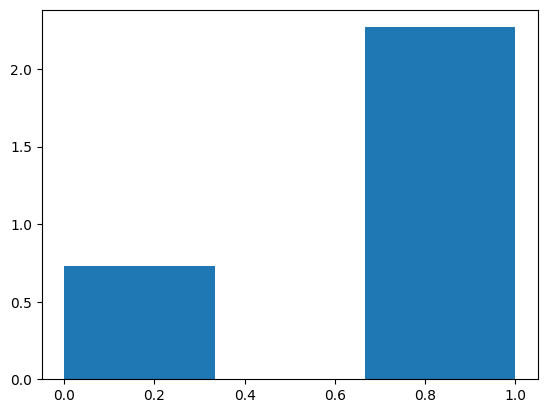

In [ ]:
true_score = 2
mask = (ground_truth_faa_scores==true_score)
plt.figure()
plt.hist(gpt_scores[mask], bins=3, density=True)
plt.show()

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix

In [ ]:
egmask = ~np.isnan(ground_truth_faa_scores)

In [ ]:
egmask.sum(), len(egmask)

(160, 160)

In [ ]:
egmask[[150, 137]] = False

In [ ]:
egmask.sum()

158

In [ ]:
ground_truth_binary = (ground_truth_faa_scores[egmask]==2).astype(int)

In [ ]:
ground_truth_faa_scores[:10], ground_truth_binary[:10]

(array([0, 2, 1, 0, 2, 2, 2, 0, 1, 2]), array([0, 1, 0, 0, 1, 1, 1, 0, 0, 1]))

In [ ]:
gpt_scores_test = gpt_scores[egmask]

In [ ]:
len(gpt_scores_test), len(ground_truth_binary)

(158, 158)

In [ ]:
conf_matrix = confusion_matrix(ground_truth_binary, gpt_scores_test)

In [ ]:
conf_matrix

array([[29, 11],
       [29, 89]])

In [ ]:
conf_matrix.sum(axis=1).sum(), conf_matrix.sum(axis=0).sum()

(158, 158)

In [ ]:
SAVDIR

'/content/drive/MyDrive/HF annotation/datasets/execution_updated/FewShot_Justify_Final'

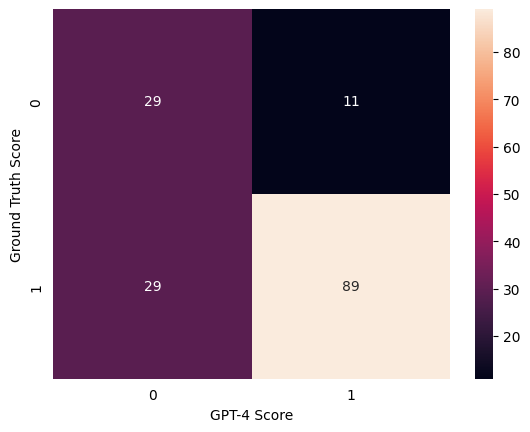

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
ax=sns.heatmap(conf_matrix, annot=True, fmt="d")
ax.grid(False)
ax.set_xlabel('GPT-4 Score')
ax.set_ylabel('Ground Truth Score')
ax.xaxis.set_ticklabels([0, 1])
ax.xaxis.set_ticklabels([0, 1])
ax.tick_params(left=False, bottom=False)
plt.savefig(os.path.join(SAVDIR, 'confusion_matrix_binary_noexample158.png'))
plt.show()

In [ ]:
(gpt_scores_test==1).sum(), (ground_truth_binary==1).sum()

(100, 118)

In [ ]:
out = sklearn.metrics.precision_recall_fscore_support(ground_truth_binary, gpt_scores_test, labels=[0, 1])

In [ ]:
out

(array([0.5 , 0.89]),
 array([0.725     , 0.75423729]),
 array([0.59183673, 0.81651376]),
 array([ 40, 118]))

In [ ]:
89/(89+29)

0.7542372881355932

In [ ]:
def get_all_scoring_metrics(ground_truth_binary, gpt_scores_test):
  metrics = {}
  metrics['accuracy_unbalanced'] = sklearn.metrics.accuracy_score(ground_truth_binary, gpt_scores_test)
  metrics['accuracy_balanced'] = sklearn.metrics.balanced_accuracy_score(ground_truth_binary, gpt_scores_test)
  out = sklearn.metrics.precision_recall_fscore_support(ground_truth_binary, gpt_scores_test, labels=[0, 1]) # Note zero_divison is 0.0 default here
  metrics['precision_classwise'] = out[0]
  metrics['recall_classwise'] = out[1]
  metrics['f1_classwise'] = out[2]
  metrics['support_classwise'] = out[3]
  metrics['Total Problems'] = len(ground_truth_binary)
  return metrics

def render_metrics(metrics):
  print('Metrics')
  for k, v in metrics.items():
    print(f'{k}: {v}')
  return

In [ ]:
sklearn.metrics.accuracy_score(ground_truth_binary, gpt_scores_test)

0.7468354430379747

In [ ]:
(ground_truth_binary==1).sum()/len(ground_truth_binary) #the score if the model had blindly predicted 2 for all blanks

0.7468354430379747

Giving all GT scores (classes) the same 'weight'

In [ ]:
sklearn.metrics.balanced_accuracy_score(ground_truth_binary, gpt_scores_test)

0.7396186440677965

In [ ]:
(29+89)/158

0.7468354430379747

In [ ]:
# GPT-4 Scores
test_scores = np.ones(len(ground_truth_binary))
print('GPT-4 Score')
metrics = get_all_scoring_metrics(ground_truth_binary, gpt_scores_test)
render_metrics(metrics)

GPT-4 Score
Metrics
accuracy_unbalanced: 0.7468354430379747
accuracy_balanced: 0.7396186440677965
precision_classwise: [0.5  0.89]
recall_classwise: [0.725      0.75423729]
f1_classwise: [0.59183673 0.81651376]
support_classwise: [ 40 118]
Total Problems: 158


In [ ]:
# random predictor
rng = np.random.default_rng(seed=23)
test_scores = rng.choice(2, size=len(ground_truth_binary))
print('Randomly predicts 0|1')
metrics = get_all_scoring_metrics(ground_truth_binary, test_scores)
render_metrics(metrics)

Randomly predicts 0|1
Metrics
accuracy_unbalanced: 0.4620253164556962
accuracy_balanced: 0.49110169491525424
precision_classwise: [0.24719101 0.73913043]
recall_classwise: [0.55       0.43220339]
f1_classwise: [0.34108527 0.54545455]
support_classwise: [ 40 118]
Total Problems: 158


In [ ]:
# Always predicts 1
test_scores = np.ones(len(ground_truth_binary))
print('Always predicts 1')
metrics = get_all_scoring_metrics(ground_truth_binary, test_scores)
render_metrics(metrics)

Always predicts 1
Metrics
accuracy_unbalanced: 0.7468354430379747
accuracy_balanced: 0.5
precision_classwise: [0.         0.74683544]
recall_classwise: [0. 1.]
f1_classwise: [0.         0.85507246]
support_classwise: [ 40 118]
Total Problems: 158


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
